# تمرین سری هفتم
object detection on **Pascal VOC** using **Fast R-CNN**

## هدف
 یادگیری استفاده از الگوریتم Fast R-CNN برای وظایف شناسایی اشیا.


# در پایان این تمرین، شما قادر خواهید بود یک مدل Fast R-CNN آموزش دهید و از آن برای شناسایی اشیا در تصاویر استفاده کنید.

------------------------------------------------------

# بخش اول


راه اندازی محیط

In [1]:
# نصب کتابخانه‌های مورد نیاز
!pip install tensorflow opencv-python matplotlib

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET



# بخش دوم



آماده سازی داده

دانلود مجموعه داده
**Pascal VOC**  
و آماده سازی آن.

 آماده‌سازی مجموعه داده با تبدیل حاشیه‌نویسی‌ها به فرمت مورد نیاز (جعبه‌های مرزی و برچسب‌های کلاس).

In [3]:
import requests
import tarfile
import zipfile

def download(url, download_dir):
    # Create download directory if it doesn't exist
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)

    # Download the file
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    if not os.path.exists(file_path):
        print(f"Downloading {filename}...")
        response = requests.get(url, stream=True)
        with open(file_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
        print(f"{filename} downloaded successfully.")
    else:
        print(f"{filename} already exists. Skipping download.")


url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2008/VOCtrainval_14-Jul-2008.tar"
download_dir = "/content/download_directory"

# Download and extract the dataset
dataset_file = download(url, download_dir)

VOCtrainval_14-Jul-2008.tar downloaded successfully.


In [4]:
def extract_tarfile(file_path, extract_dir):
    """
    Extracts a .tar file to the specified directory.

    Inputs:
    - file_path (str): Path to the .tar file.
    - extract_dir (str): Directory where the contents of the .tar file will be extracted.
    """
    with tarfile.open(file_path, 'r') as tar:
        tar.extractall(path=extract_dir)
    print(f"{file_path} extracted successfully to {extract_dir}")

# Example usage:
tar_file = '/content/download_directory/VOCtrainval_14-Jul-2008.tar'  # Replace with your downloaded .tar file path
extract_dir = 'download_directory'    # Replace with the directory where you want to extract the files

extract_tarfile(tar_file, extract_dir)

/content/download_directory/VOCtrainval_14-Jul-2008.tar extracted successfully to download_directory


In [5]:
import os
import xml.etree.ElementTree as ET

def load_pascal_voc_dataset(data_path):
    """
    بارگذاری مجموعه داده Pascal VOC و آماده‌سازی آن.

    ورودی‌ها:
    - data_path (str): مسیر دایرکتوری که مجموعه داده در آن قرار دارد.

    خروجی‌ها:
    - images (list of str): لیست مسیرهای تصاویر.
    - bboxes (list of list): لیست جعبه‌های مرزی برای هر تصویر.
    - labels (list of list): لیست برچسب‌ها برای هر تصویر.
    """
    images = []
    bboxes = []
    labels = []

    for root_dir, _, files in os.walk(data_path):
        for file in files:
            if file.endswith('.xml'):
                tree = ET.parse(os.path.join(root_dir, file))
                root = tree.getroot()
                filename = root.find('filename').text
                image_path = os.path.join(data_path, 'JPEGImages', filename)
                images.append(image_path)
                boxes = []
                lbls = []
                for obj in root.findall('object'):
                    bbox = obj.find('bndbox')
                    box = [
                        int(float(bbox.find('xmin').text)),
                        int(float(bbox.find('ymin').text)),
                        int(float(bbox.find('xmax').text)),
                        int(float(bbox.find('ymax').text))
                    ]
                    boxes.append(box)
                    lbls.append(obj.find('name').text)
                bboxes.append(boxes)
                labels.append(lbls)

    return images, bboxes, labels


data_path = '/content/download_directory/VOCdevkit/VOC2008/'  # مسیر خود را به مجموعه داده Pascal VOC تنظیم کنید
images, bboxes, labels = load_pascal_voc_dataset(data_path)



In [6]:
len(images),len(bboxes),len(labels)

(5096, 5096, 5096)

# بخش سوم


بارگزاری و نمایش مجموعه داده ها

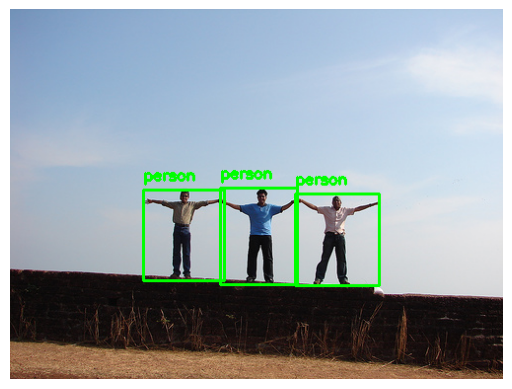

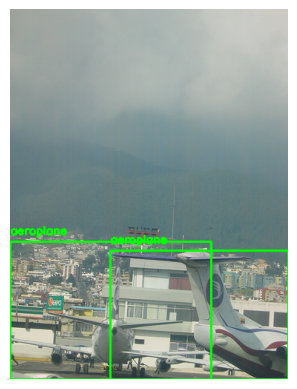

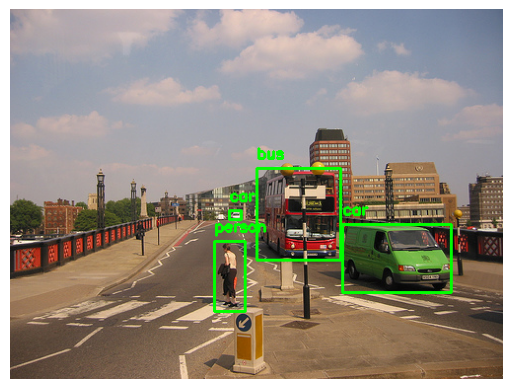

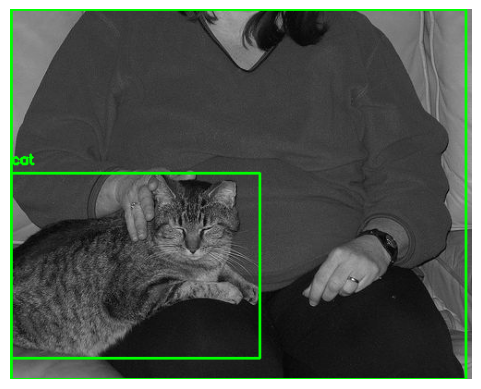

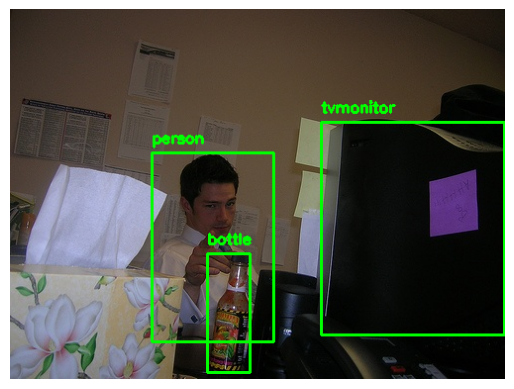

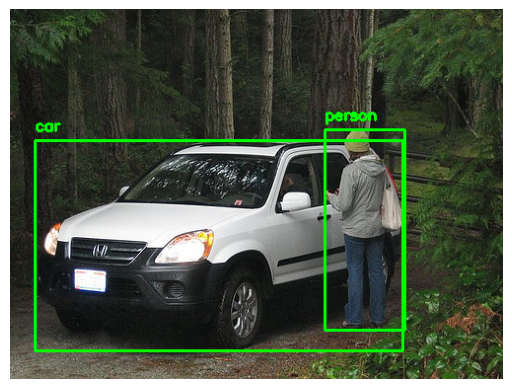

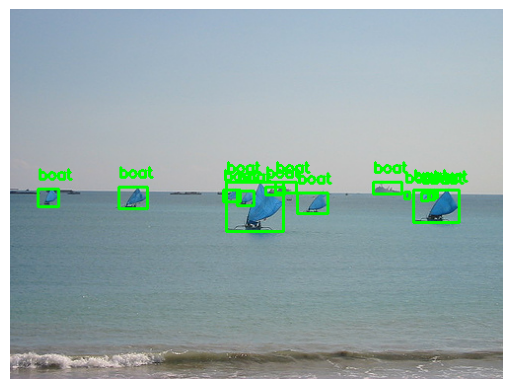

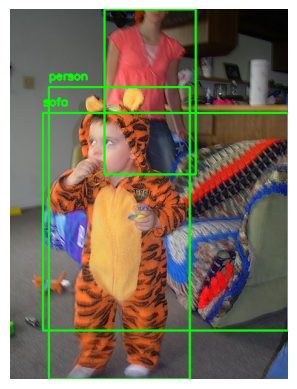

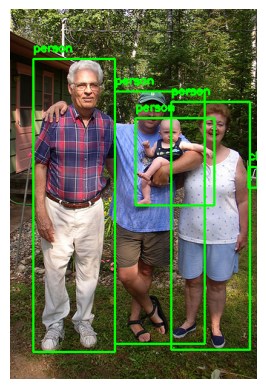

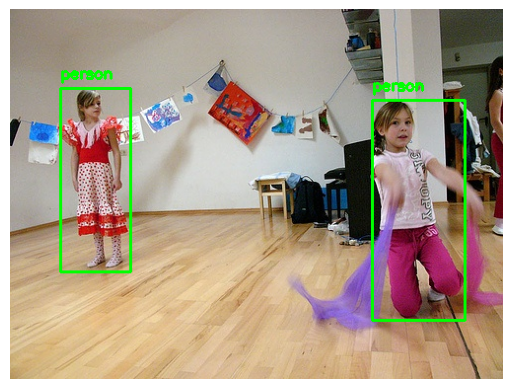

In [7]:
#TODO: نوشتن تابع برای نمایش تصاویر و جعبه‌های مرزی آن‌ها
def visualize_image_with_bboxes(image_path, bboxes, labels=None):
    """
    نمایش یک تصویر با جعبه‌های مرزی.

    ورودی‌ها:
    - image_path (str): مسیر فایل تصویر.
    - bboxes (list of list): لیست جعبه‌های مرزی، هرکدام به صورت [xmin, ymin, xmax, ymax].
    - labels (list of str, اختیاری): لیست برچسب‌ها که متناظر با جعبه‌های مرزی هستند.

    خروجی‌ها:
    - هیچکدام: تصویر با جعبه‌های مرزی نمایش داده می‌شود.
    """
    image = cv2.imread(image_path)
    for i, bbox in enumerate(bboxes):
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        if labels:
            cv2.putText(image, labels[i], (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# نمایش نمونه‌ای از داده‌ها
# در صورت سوال گفته شده این کار را برای 10 تا از تصاویر انجام دهیم
for i in range(10):
  visualize_image_with_bboxes(images[i], bboxes[i], labels[i])



# مرحله 4


آماده سازی مدل

بارگذاری یک مدل پیش‌آموزش دیده

***Fast R-CNN***

از مدل

***zoo***

در


***tensorflow***

In [8]:
# مرحله 4: آماده‌سازی مدل
#  از مدل زو TensorFlow (Fast R-CNN می‌تواند به روشی مشابه استفاده شود).

# TODO: نوشتن تابع برای بارگذاری یک مدل Faster R-CNN پیش‌آموزش دیده
import tensorflow_hub as hub
def load_pretrained_model():
    """
    بارگذاری یک مدل Faster R-CNN پیش‌آموزش دیده از مدل زو TensorFlow.

    خروجی‌ها:
    - model: مدل Faster R-CNN پیش‌آموزش دیده.
    """
    # دانشجویان باید این قسمت را تکمیل کنند
    model_url = "https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1"
    model = hub.load(model_url)
    # model = tf.keras.applications.ResNet50(include_top=False,
    #         input_shape=(None, None, 3))

    # Load the model from TensorFlow Hub
    # model = tf.keras.applications.ResNet50(include_top=False,
    # input_shape=(None, None, 3))

    return model
model = load_pretrained_model()

# مرحله ششم

استنتاج

نوشتن تابع برای انجام استنتاج بر روی یک تصویر با استفاده از مدل


***Faster R-CNN.***

In [9]:
# TODO: نوشتن تابع برای پیش‌پردازش تصویر برای استنتاج مدل
def preprocess_image(image_path):
    """
    پیش‌پردازش یک تصویر برای استنتاج مدل.

    ورودی‌ها:
    - image_path (str): مسیر فایل تصویر.

    خروجی‌ها:
    - input_image (آرایه numpy): تصویر پیش‌پردازش شده آماده برای ورودی مدل.
    - original_image (آرایه numpy): تصویر اصلی برای نمایش.
    """
    # دانشجویان باید این قسمت را تکمیل کنند
    original_image = cv2.imread(image_path)
    if original_image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")

    # Convert BGR to RGB
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Resize image to a fixed size (assuming 640x640 for the model)
    input_image = cv2.resize(original_image, (640, 640))

    # Normalize the image to [0, 1]
    #input_image = input_image / 255.0

    # Expand dimensions to match the model input shape (batch size, height, width, channels)
    input_image = np.expand_dims(input_image, axis=0)

    return input_image,original_image

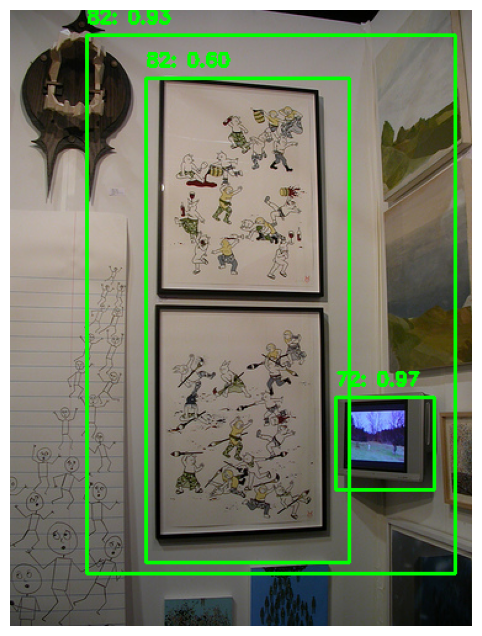

In [10]:
def detect_objects(model, image_path, threshold=0.6):
    """
    شناسایی اشیا در یک تصویر با استفاده از یک مدل پیش‌آموزش دیده.

    ورودی‌ها:
    - model: مدل پیش‌آموزش دیده.
    - image_path (str): مسیر فایل تصویر.
    - threshold (شناور): آستانه شناسایی.

    خروجی‌ها:
    - هیچکدام: تصویر با جعبه‌های مرزی شناسایی شده نمایش داده می‌شود.
    """
    # Preprocess the image
    input_image, original_image = preprocess_image(image_path)

    # Run the model to make predictions
    detections = model(input_image)

    # Extract the boxes, scores, and classes
    boxes = detections['detection_boxes'][0].numpy()
    scores = detections['detection_scores'][0].numpy()
    classes = detections['detection_classes'][0].numpy().astype(int)

    # Draw the bounding boxes on the original image
    height, width, _ = original_image.shape
    for box, score, classes in zip(boxes, scores, classes):
        if score > threshold:
            ymin, xmin, ymax, xmax = box
            xmin = int(xmin * width)
            xmax = int(xmax * width)
            ymin = int(ymin * height)
            ymax = int(ymax * height)
            cv2.rectangle(original_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            label = f'{classes}: {score:.2f}'
            cv2.putText(original_image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 8))
    plt.imshow(original_image)
    plt.axis('off')
    plt.show()


# Example usage
image_path = images[75]
detect_objects(model, image_path)

# مرحله هفتم

ارزیابی

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,precision_recall_curve, auc

def load_coco_dataset(split='validation'):
    """
    Load the MS COCO dataset.

    Inputs:
    - split: Dataset split to load ('train', 'validation', 'test').

    Outputs:
    - dataset: TensorFlow dataset with images and labels.
    """
    dataset, info = tfds.load('coco/2017', split=split, with_info=True)
    dataset = dataset.map(lambda x: (preprocess_image(x['image']), x['objects']))
    return dataset


def calculate_map(y_true, y_pred, num_classes):
    """
    Calculate mean Average Precision (mAP).

    Inputs:
    - y_true: List of true labels for each class.
    - y_pred: List of predicted scores for each class.
    - num_classes: Number of classes.

    Outputs:
    - mAP: Mean Average Precision.
    """
    average_precisions = []

    for i in range(num_classes):
        # Get true labels and predicted scores for the current class
        true_class = [y[i] for y in y_true]
        pred_class = [y[i] for y in y_pred]

        # Compute precision-recall curve
        precision, recall, _ = precision_recall_curve(true_class, pred_class)

        # Compute Average Precision (AP) using the area under the precision-recall curve
        ap = auc(recall, precision)
        average_precisions.append(ap)

    # Compute mean Average Precision (mAP)
    mAP = np.mean(average_precisions)
    return mAP

def evaluate_model(model, dataset, threshold=0.5, iou_threshold=0.5):
    """
    ارزیابی عملکرد مدل بر روی یک مجموعه اعتبارسنجی.

    ورودی‌ها:
    - model: مدل آموزش دیده.
    - dataset: مجموعه داده اعتبارسنجی.

    خروجی‌ها:
    - metrics: دیکشنری حاوی معیارهای ارزیابی مانند میانگین دقت متوسط (mAP).
    """
    # دانشجویان باید این قسمت را تکمیل کنند
    y_true = []
    y_pred = []

    for image, label in dataset:
        # Perform prediction
        image_np = tf.expand_dims(image, axis=0)
        outputs = model(image_np)

        # Extract predictions
        num_detections = int(outputs["num_detections"][0])
        detection_boxes = outputs["detection_boxes"][0][:num_detections]
        detection_scores = outputs["detection_scores"][0][:num_detections]
        detection_classes = outputs["detection_classes"][0][:num_detections]

        # Convert detection_classes to integers
        detection_classes = detection_classes.numpy().astype(int)

        # Assuming that label contains the ground truth bounding boxes and classes
        true_boxes = label['bbox']
        true_classes = label['label']

        # Map the true and predicted classes to 0 or 1 (binary classification)
        y_true.extend([1 if cls in true_classes.numpy() else 0 for cls in detection_classes])
        y_pred.extend([1 if score >= 0.5 else 0 for score in detection_scores.numpy()])

    # Calculate evaluation metrics
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    conf_matrix = confusion_matrix(y_true, y_pred)

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }

    return metrics

# Example usage:
if __name__ == "__main__":
    validation_dataset = load_coco_dataset(split='validation')
    model = load_pretrained_model()
    metrics = evaluate_model(model, validation_dataset)
    print(metrics)





Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

KeyboardInterrupt: 